In [1]:
import numpy

def densify_box(minx, miny, maxx, maxy):
    """
    Add intermediate points along the edges of the box.
    """
    xx = numpy.arange(minx, maxx, 1)
    yy =  numpy.arange(miny, maxy, 1)

    xbox = numpy.concatenate((
        numpy.ones(len(yy)) * minx,
        xx,
        numpy.ones(len(yy)) * maxx,
        xx[::-1],
    ))

    ybox = numpy.concatenate((
        yy,
        numpy.ones(len(xx)) * maxy,
        yy[::-1],
        numpy.ones(len(xx)) * miny,    

    ))
    return xbox, ybox

In [15]:
import geopandas
from pyproj import CRS, Transformer
from shapely.geometry import Polygon, box

proj_crs = CRS("EPSG:3035")
min_lon, min_lat, max_lon, max_lat = proj_crs.area_of_use.bounds
transformer = Transformer.from_crs("EPSG:4326", proj_crs, always_xy=True)
xbox, ybox = transformer.transform(*densify_box(min_lon, min_lat, max_lon, max_lat))
projected_bounding_polygon = Polygon(zip(xbox, ybox))
bounding_polygon = Polygon(zip(*densify_box(min_lon, min_lat, max_lon, max_lat)))


<AxesSubplot: >

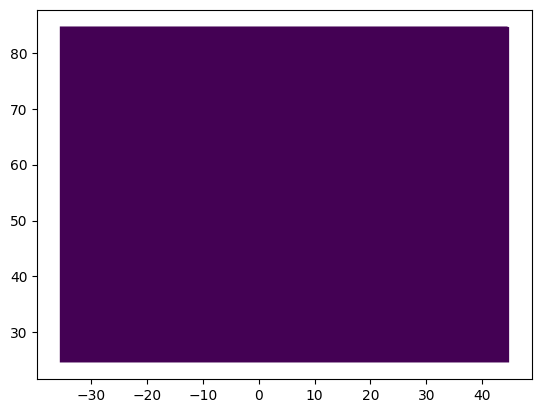

In [18]:
gs = geopandas.GeoSeries([bounding_polygon])
gs.plot(cmap="viridis")

In [11]:
xx, yy = transformer.transform(
    [min_lon, max_lon, max_lon, min_lon],
    [min_lat, min_lat, max_lat, max_lat]
)
simple_bounding_polygon = box(min(xx), min(yy), max(xx), max(yy))

<AxesSubplot: >

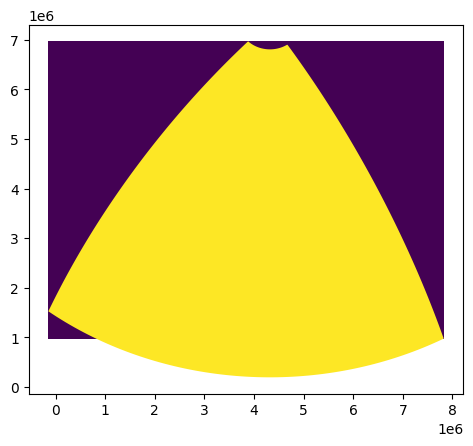

In [22]:
gs = geopandas.GeoSeries([simple_bounding_polygon, projected_bounding_polygon])
gs.plot(cmap="viridis")

In [6]:
real_bounds = box(*transformer.transform_bounds(min_lon, min_lat, max_lon, max_lat))

<AxesSubplot: >

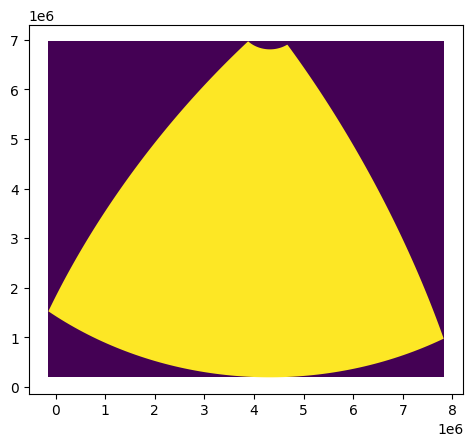

In [8]:
gs = geopandas.GeoSeries([real_bounds, projected_bounding_polygon])
gs.plot(cmap="viridis")

In [38]:
proj_crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

---
## Test environmental_raster

In [191]:
from __future__ import annotations
import warnings
from pathlib import Path
from typing import Any, Callable, Dict, Optional, Sequence, Tuple, Union, TYPE_CHECKING
import torch

import matplotlib.pyplot as plt
import numpy as np
import rasterio, pyproj
from pyproj import CRS, Transformer

from malpolon.data.utils import is_bbox_contained, is_point_in_bbox

from torch.utils.data import DataLoader
from torchgeo.datasets import BoundingBox, GeoDataset, RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import BoundingBox
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler, Units
from torchgeo.samplers.constants import Units

if TYPE_CHECKING:
    import numpy.typing as npt

    Coordinates = tuple[float, float]
    Patch = npt.NDArray[np.float32]


# fmt: off
bioclimatic_raster_names = [
    "bio_1", "bio_2", "bio_3", "bio_4", "bio_5", "bio_6", "bio_7", "bio_8", "bio_9",
    "bio_10", "bio_11", "bio_12", "bio_13", "bio_14", "bio_15", "bio_16", "bio_17",
    "bio_18", "bio_19"
]

pedologic_raster_names = [
    "bdticm", "bldfie", "cecsol", "clyppt", "orcdrc", "phihox", "sltppt", "sndppt"
]

raster_names = bioclimatic_raster_names + pedologic_raster_names
# fmt: on

ALL_NORTHERN_EPSG_CODES = list(range(32601, 32662))
EUROPE_EPSG_CODE = [3035]


class RasterTorchGeo(RasterDataset):
    def __init__(self,
        root: str = "data",
        crs: Any | None = None,
        res: float | None = None,
        bands: Sequence[str] | None = None,
        transforms: Callable[[Dict[str, Any]], Dict[str, Any]] | None = None,
        cache: bool = True,
        patch_size: int = 256
    ) -> None:
        super().__init__(root, crs, res, bands, transforms, cache)
        self.patch_size = patch_size
        self.crs_pyproj = CRS(self.crs.data['init'])

    def coords_transform(
        self,
        lon: Union[int, float],
        lat: Union[int, float],
        input_crs: Union[str, int, CRS] = "4326",
        output_crs: Union[str, int, CRS] = "self",
    ) -> tuple[float, float]:
        """Transform coordinates from one CRS to another.

        Parameters
        ----------
        lon : Union[int, float]
            longitude
        lat : Union[int, float]
            latitude
        input_crs : Union[str, int, CRS], optional
            Input CRS, by default "4326"
        output_crs : Union[str, int, CRS], optional
            Output CRS, by default "self"

        Returns
        -------
        tuple
            Transformed coordinates.
        """
        if not isinstance(input_crs, CRS):
            input_crs = self.crs if input_crs == "self" else rasterio.CRS.from_epsg(input_crs)
        if not isinstance(output_crs, CRS):
            output_crs = self.crs if output_crs == "self" else rasterio.CRS.from_epsg(output_crs)
        if input_crs == output_crs:
            return lon, lat
        transformer = Transformer.from_crs(input_crs, output_crs, always_xy=True)
        return transformer.transform(lon, lat)

    def point_to_bbox(self,
        lon: Union[int, float],
        lat: Union[int, float],
        size: Union[tuple, int] = None,
        units: str = 'crs',
        crs: Union[int, str] = 'self',
    ) -> BoundingBox:
        """Convert a geographical point to a torchgeo BoundingBox.
        
        This method converts a 2D point into a 2D torchgeo bounding box (bbox).
        If 'size' is in the CRS' unit system, the bbox is computed directly
        from the point's coordinates.
        If 'size' is in pixels, 'size' is multiplied by the resolution of the
        dataset.
        If 'size' is in meters and the dataset's unit system isn't, the point is
        projected into the nearest meter-based CRS (from a list defined as
        constant at the begining of this file), the bbox vertices' min and max
        are computed in thise reference system, then they are projected back
        into the input CRS 'crs'.
        
        By default, 'size' is set to the dataset's 'patch_size' value via None.

        Parameters
        ----------
        lon : Union[int, float]
            longitude
        lat : Union[int, float]
            latitude
        size : Union[tuple, int], optional
            Patch size, by default None. If passed as an int, the patch will be
            square. If passed as a tuple (width, height), can be rectangular.
        units : str, optional
            The coordinates' unit system, must have a value in ['pixel', 'crs'].
            The size of the bbox will adapt to the unit. If 'pixel' is
            selected, the bbox size will be multiplied by the dataset
            resolution. Selecting 'crs' will not modify the bbox size. In that
            case the returned bbox will be of size:
            (size[0], size[1]) <metric_of_the_dataset (usually meters)>.
            Defaults to 'crs'.
        crs : Union[int, str]
            CRS of the point's lon/lat coordinates, by default None.
            
        Returns
        -------
        BoundingBox
            Corresponding torchgeo BoundingBox.
        """
        crs = self.crs_pyproj if crs == 'self' else crs
        units = {'pixel': Units.PIXELS, 'crs': Units.CRS, 'm': 'm', 'meter': 'meter', 'metre': 'metre'}[units]
        size = self.patch_size if size is None else size
        size = (size, size) if isinstance(size, int) else size
        if units == Units.PIXELS:
            size = (size[0] * self.res, size[1] * self.res)

        # Compute the new value of size if the query is in meters but the dataset's unit isn't.
        if units == 'm' and not self.crs_pyproj.axis_info[0].unit_name in ['metre', 'meter', 'm']:  # isinstance(self.crs, rasterio.CRS.from_epsg(4326)):
            # Find closest meter EPSG
            best_crs = {'code': '',
                        'center_distance': np.inf}
            lon_geodetic, lat_geodetic = self.coords_transform(lon, lat, input_crs=crs, output_crs=self.crs_pyproj.geodetic_crs)
            for code in ALL_NORTHERN_EPSG_CODES:
                epsg_aou = CRS.from_epsg(code).area_of_use
                epsg_lon_center, epsg_lat_center = (epsg_aou.west + epsg_aou.east)/2, (epsg_aou.south + epsg_aou.north)/2
                center_distance = np.linalg.norm(np.array([lon_geodetic, lat_geodetic]) - np.array([epsg_lon_center, epsg_lat_center]))
                if center_distance <= best_crs['center_distance']:
                    best_crs['code'] = code
                    best_crs['center_distance'] = center_distance
            best_crs = CRS.from_epsg(best_crs['code'])

            # Project lon, lat to best meter EPSG, compute bbox and project back to dataset's crs
            transformer = Transformer.from_crs(crs, best_crs, always_xy=True)
            lon_proj, lat_proj = transformer.transform(lon, lat)
            bounds_proj = (lon_proj - size[0]/2, lon_proj + size[0]/2), (lat_proj - size[1]/2, lat_proj + size[1]/2)  # (xmin, xmax, ymin, ymax)
            bounds = transformer.transform(*bounds_proj, direction="INVERSE")  # (xmin, xmax, ymin, ymax)
            size = (bounds[0][1] - bounds[0][0]), (bounds[1][1] - bounds[1][0])

        minx = lon - size[0]/2
        maxx = lon + size[0]/2
        miny = lat - size[1]/2
        maxy = lat + size[1]/2
        return BoundingBox(minx=minx, maxx=maxx, miny=miny, maxy=maxy, mint=0, maxt=0)

    def __getitem__(self, query: Union[dict, tuple, list, set, BoundingBox]) -> Dict[str, Any]:
        """Query an item from the dataset.
        
        Supports querying the dataset with coordinates in the dataset's CRS
        or in another CRS.
        The dataset is always queried with a torchgeo BoundingBox because it is
        itself a torchgeo dataset, but the query in this getter method can be
        passed as a tuple, list, set, dict or BoundingBox.
        Use case 1:
            query is a [list, tuple, set] of 2 elements : lon, lat.
            Here the CRS and Units system are by default those of the dataset's.
        Use case 2:
            query is a torchgeo BoundingBox.
            Here the CRS and Units system are by default those of the dataset's.
        Use case 3:
            query is a dict containing the following necessary keys: {'lon', 'lat'},
            and optional keys: {'crs', 'units', 'size'} which values default to those of
            the dataset's.
            
        In Use case 3, if the 'crs' key is registered and it is different from
        the dataset's CRS, the coordinates of the point are projected into the
        dataset's CRS and the value of the key is overwritten by said CRS.
        
        Use cases 1 and 3 give the possibility to easily query the dataset using
        only a point and a bounding box (bbox) size, using the desired input CRS.
        
        The unit of measurement of the bbox can be set to ['m', 'meters', 'metres']
        even if the dataset's unit is different as the points will be projected
        in the nearest meter-based CRS (see self.point_to_bbox()).

        Parameters
        ----------
        query : Union[dict, tuple, BoundingBox]
            item query containing geographical coordinates. It can be of
            different types for different use.
            One can query a patch by providing a BoundingBox using
            `torchgeo.datasets.BoundingBox` constructor; or by given a center
            and a size.
            --- BoundingBox strategy ---
            Must follow : BoundingBox(minx, maxx, miny, maxy, mint, maxt)
            --- Point strategy ---
            If tuple, must follow : (lon, lat) and the CRS of the coordinates
            will be assumed to be the dataset's.
            If dict, must follow : {'lon': lon, 'lat': lat, ['crs': crs]} and
            the coordinates CRS can be specified. If not, it will be assumed
            taht it is equal to the dataset's.
            In both cases, a BoundingBox is generated to pursue the query.

        Returns
        -------
        Dict[str, Any]
            dataset patch.
        """
        if not isinstance(query, BoundingBox):
            # Use case 1
            if isinstance(query, (tuple, list, set)):
                query = {'lon': query[0], 'lat': query[1], 'crs': self.crs_pyproj, 'size': self.patch_size}

            # Use Case 3
            if 'crs' in query.keys() and query['crs'] != self.crs_pyproj:
                transformer = Transformer.from_crs(query['crs'], self.crs_pyproj, always_xy=True)
                query['lon'], query['lat'] = transformer.transform(query['lon'], query['lat'])
                if not is_point_in_bbox((query['lon'], query['lat']), transformer.transform_bounds(*self.crs_pyproj.area_of_use.bounds)):
                    raise Exception("Your chosen point lands outside of your dataset CRS after projection.")
                    
            if 'size' not in query.keys():
                query['size'] = self.patch_size
            if 'units' not in query.keys():
                query['units'] = 'pixel'
            if 'crs' not in query.keys() or query['crs'] != self.crs_pyproj:
                query['crs'] = self.crs_pyproj

            query = self.point_to_bbox(query['lon'], query['lat'], query['size'], query['units'], query['crs'])

        # Use Case 2
        return super().__getitem__(query)


class Raster(object):
    """Loads a GeoTIFF file and extract patches for a single environmental raster

    Parameters
    ----------
    path : string / pathlib.Path
        Path to the folder containing all the rasters.
    country : string, either "FR" or "USA"
        Which country to load raster from.
    size : integer
        Size in pixels (size x size) of the patch to extract around each location.
    nan : float or None
        Value to use to replace missing data in original rasters, if None, leaves default values.
    out_of_bounds : string, either "error", "warn" or "ignore"
        If "error", raises an exception if the location requested is out of bounds of the rasters. Set to "warn" to only produces a warning and to "ignore" to silently ignore it and return a patch filled with missing data.
    """

    def __init__(
        self,
        path: Union[str, Path],
        country: str,
        size: int = 256,
        nan: Optional[float] = np.nan,
        out_of_bounds: str = "error",
    ):
        path = Path(path)
        if not path.exists():
            raise ValueError(
                "path should be the path to a raster, given non-existant path: {}".format(
                    path
                )
            )

        self.path = path
        self.name = path.name
        self.size = size
        self.out_of_bounds = out_of_bounds
        self.nan = nan

        # Loading the raster
        filename = path / "{}_{}.tif".format(self.name, country)
        with rasterio.open(filename) as dataset:
            self.dataset = dataset
            raster = dataset.read(1, masked=True, out_dtype=np.float32)

        # Changes nodata to user specified value
        if nan:
            raster[np.isnan(raster)] = nan
            raster = raster.filled(nan)
        else:
            raster = raster.data

        self.raster = raster

        # setting the shape of the raster
        self.shape = self.raster.shape

    def _extract_patch(self, coordinates: Coordinates) -> Patch:
        """Extracts the patch around the given GPS coordinates.
        Avoid using this method directly.

        Parameter
        ----------
        coordinates : tuple containing two floats
            GPS coordinates (latitude, longitude)

        Returns
        -------
        patch : 2d array of floats, [size, size], or single float if size == 1
            Extracted patch around the given coordinates.
        """
        row, col = self.dataset.index(coordinates[1], coordinates[0])

        if self.size == 1:
            # Environmental vector
            patch = self.raster[row, col]
        else:
            half_size = self.size // 2
            height, width = self.shape

            # FIXME: only way to trigger an exception? (slices don't)
            self.raster[row, col]

            raster_row_slice = slice(max(0, row - half_size), row + half_size)
            raster_col_slice = slice(max(0, col - half_size), col + half_size)

            patch_row_slice = slice(
                max(0, half_size - row), self.size - max(0, half_size - (height - row))
            )
            patch_col_slice = slice(
                max(0, half_size - col), self.size - max(0, half_size - (width - col))
            )

            patch = np.full(
                (self.size, self.size), fill_value=self.nan, dtype=np.float32
            )
            patch[patch_row_slice, patch_col_slice] = self.raster[
                raster_row_slice, raster_col_slice
            ]

        patch = patch[np.newaxis]
        return patch

    def __len__(self) -> int:
        """Number of bands in the raster (should always be equal to 1).

        Returns
        -------
        n_bands : integer
            Number of bands in the raster
        """
        return self.dataset.count

    def __getitem__(self, coordinates: Coordinates) -> Patch:
        """Extracts the patch around the given GPS coordinates.

        Parameters
        ----------
        coordinates : tuple containing two floats
            GPS coordinates (latitude, longitude)

        Returns
        -------
        patch : 2d array of floats, [size, size], or single float if size == 1
            Extracted patch around the given coordinates.
        """
        try:
            return self._extract_patch(coordinates)
        except IndexError as e:
            if self.out_of_bounds == "error":
                raise e
            else:
                if self.out_of_bounds == "warn":
                    warnings.warn(
                        "GPS coordinates ({}, {}) out of bounds".format(*coordinates)
                    )

                if self.size == 1:
                    patch = np.array([self.nan], dtype=np.float32)
                else:
                    patch = np.full(
                        (1, self.size, self.size), fill_value=self.nan, dtype=np.float32
                    )

                return patch

    def __repr__(self) -> str:
        return str(self)

    def __str__(self) -> str:
        return "name: " + self.name + "\n"


class PatchExtractor(object):
    """Handles the loading and extraction of an environmental tensor from multiple rasters given GPS coordinates.

    Parameters
    ----------
    root_path : string or pathlib.Path
        Path to the folder containing all the rasters.
    size : integer
        Size in pixels (size x size) of the patches to extract around each location.
    """

    def __init__(self, root_path: Union[str, Path], size: int = 256):
        self.root_path = Path(root_path)
        if not self.root_path.exists():
            raise ValueError(
                "root_path should be the directory containing the rasters, given a non-existant path: {}".format(
                    root_path
                )
            )

        self.size = size

        self.rasters_fr: list[Raster] = []
        self.rasters_us: list[Raster] = []

    def add_all_rasters(self, **kwargs: Any) -> None:
        """Add all variables (rasters) available

        Parameters
        ----------
        kwargs : dict
            Updates the default arguments passed to Raster (nan, out_of_bounds, etc.)
        """
        for raster_name in raster_names:
            self.append(raster_name, **kwargs)

    def add_all_bioclimatic_rasters(self, **kwargs: Any) -> None:
        """Add all bioclimatic variables (rasters) available

        Parameters
        ----------
        kwargs : dict
            Updates the default arguments passed to Raster (nan, out_of_bounds, etc.)
        """
        for raster_name in bioclimatic_raster_names:
            self.append(raster_name, **kwargs)

    def add_all_pedologic_rasters(self, **kwargs: Any) -> None:
        """Add all pedologic variables (rasters) available

        Parameters
        ----------
        kwargs : dict
            Updates the default arguments passed to Raster (nan, out_of_bounds, etc.)
        """
        for raster_name in pedologic_raster_names:
            self.append(raster_name, **kwargs)

    def append(self, raster_name: str, **kwargs: Any) -> None:
        """Loads and appends a single raster to the rasters already loaded.

        Can be useful to load only a subset of rasters or to pass configurations specific to each raster.

        Parameters
        ----------
        raster_name : string
            Name of the raster to load, should be a subfolder of root_path.
        kwargs : dict
            Updates the default arguments passed to Raster (nan, out_of_bounds, etc.)
        """
        r_us = Raster(self.root_path / raster_name, "USA", size=self.size, **kwargs)
        r_fr = Raster(self.root_path / raster_name, "FR", size=self.size, **kwargs)

        self.rasters_us.append(r_us)
        self.rasters_fr.append(r_fr)

    def clean(self) -> None:
        """Remove all rasters from the extractor."""
        self.rasters_fr = []
        self.rasters_us = []

    def _get_rasters_list(self, coordinates: Coordinates) -> list[Raster]:
        """Returns the list of rasters from the appropriate country

        Parameters
        ----------
        coordinates : tuple containing two floats
            GPS coordinates (latitude, longitude)

        Returns
        -------
        rasters : list of Raster objects
            All previously loaded rasters.
        """
        if coordinates[1] > -10.0:
            return self.rasters_fr
        else:
            return self.rasters_us

    def __repr__(self) -> str:
        return str(self)

    def __str__(self) -> str:
        result = ""

        for rasters in [self.rasters_fr, self.rasters_us]:
            for raster in rasters:
                result += "-" * 50 + "\n"
                result += str(raster)

        return result

    def __getitem__(self, coordinates: Coordinates) -> npt.NDArray[np.float32]:
        """Extracts the patches around the given GPS coordinates for all the previously loaded rasters.

        Parameters
        ----------
        coordinates : tuple containing two floats
            GPS coordinates (latitude, longitude)

        Returns
        -------
        patch : 3d array of floats, [n_rasters, size, size], or 1d array of floats, [n_rasters,], if size == 1
            Extracted patches around the given coordinates.
        """
        rasters = self._get_rasters_list(coordinates)
        return np.concatenate([r[coordinates] for r in rasters])

    def __len__(self) -> int:
        """Number of variables/rasters loaded.

        Returns
        -------
        n_rasters : integer
            Number of loaded rasters
        """
        return len(self.rasters_fr)

    def plot(
        self,
        coordinates: Coordinates,
        return_fig: bool = False,
        n_cols: int = 5,
        fig: Optional[plt.Figure] = None,
        resolution: float = 1.0,
    ) -> Optional[plt.Figure]:
        """Plot an environmental tensor (only works if size > 1)

        Parameters
        ----------
        coordinates : tuple containing two floats
            GPS coordinates (latitude, longitude)
        return_fig : boolean
            If True, returns the created plt.Figure object
        n_cols : integer
            Number of columns to use
        fig : plt.Figure or None
            If not None, use the given plt.Figure object instead of creating a new one
        resolution : float
            Resolution of the created figure

        Returns
        -------
        fig : plt.Figure
            If return_fig is True, the used plt.Figure object
        """
        if self.size <= 1:
            raise ValueError("Plot works only for tensors: size must be > 1")

        rasters = self._get_rasters_list(coordinates)

        # Metadata are the name of the variables and the bounding boxes in latitude-longitude coordinates
        metadata = [
            (
                raster.name,
                [
                    coordinates[1] - (self.size // 2) * raster.dataset.res[0],
                    coordinates[1] + (self.size // 2) * raster.dataset.res[0],
                    coordinates[0] - (self.size // 2) * raster.dataset.res[1],
                    coordinates[0] + (self.size // 2) * raster.dataset.res[1],
                ],
            )
            for raster in rasters
        ]

        # Extracts the patch
        patch = self[coordinates]

        # Computing number of rows and columns
        n_rows = (patch.shape[0] + (n_cols - 1)) // n_cols

        if fig is None:
            fig = plt.figure(
                figsize=(n_cols * 6.4 * resolution, n_rows * 4.8 * resolution)
            )

        axes = fig.subplots(n_rows, n_cols)
        axes = axes.ravel()

        for i, (ax, k) in enumerate(zip(axes, metadata)):
            p = np.squeeze(patch[i])
            im = ax.imshow(p, extent=k[1], aspect="equal", interpolation="none")

            ax.set_title(k[0], fontsize=20)
            fig.colorbar(im, ax=ax)

        for ax in axes[len(metadata) :]:
            ax.axis("off")

        fig.tight_layout()

        if return_fig:
            return fig

        return None


In [192]:
dataset = RasterTorchGeo('/home/waramz/Documents/INRIA_Pl@ntNet/git/malpolon/malpolon/data/torchgeo/dataset/microlifeclef')
# res = dataset[{'lon':3.5, 'lat':44, 'crs':dataset.crs_pyproj.geodetic_crs, 'units':'crs', 'size':[1, 1]}]
res = dataset[{'lon':3.5, 'lat':44, 'crs':dataset.crs_pyproj.geodetic_crs, 'units':'crs', 'size':[0.00833333*5, 0.00833333*10]}]
print(res['image'].shape)

torch.Size([1, 10, 5])


In [6]:
dataset[BoundingBox(minx=0, maxx=1, miny=41, maxy=42, mint=0, maxt=0)]

{'crs': CRS.from_epsg(4326),
 'bbox': BoundingBox(minx=0, maxx=1, miny=41, maxy=42, mint=0, maxt=0),
 'image': tensor([[[ 1.4867e+01,  1.4842e+01,  1.4838e+01,  ...,  1.1642e+01,
            1.1663e+01,  1.1717e+01],
          [ 1.4871e+01,  1.4879e+01,  1.4879e+01,  ...,  1.1425e+01,
            1.1896e+01,  1.2146e+01],
          [ 1.4783e+01,  1.4792e+01,  1.4825e+01,  ...,  1.1496e+01,
            1.1463e+01,  1.1754e+01],
          ...,
          [ 1.3892e+01,  1.3967e+01,  1.4012e+01,  ..., -3.4000e+38,
           -3.4000e+38, -3.4000e+38],
          [ 1.3846e+01,  1.3892e+01,  1.3996e+01,  ..., -3.4000e+38,
           -3.4000e+38, -3.4000e+38],
          [ 1.3879e+01,  1.3975e+01,  1.4033e+01,  ..., -3.4000e+38,
           -3.4000e+38, -3.4000e+38]]])}

In [34]:
res = 0.00833333
print(res/1.2547988469613358e-05, res/8.948587421286902e-06)

664.116804074237 931.2453024906113


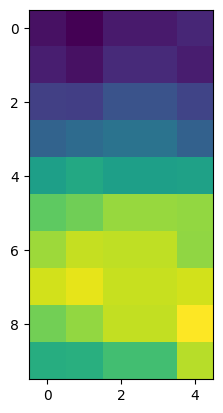

In [37]:
plt.figure()
plt.imshow(res['image'][0])
plt.show()

In [22]:
dataset.bounds

BoundingBox(minx=-7.0, maxx=11.000000000000004, miny=40.0, maxy=52.0, mint=0.0, maxt=9.223372036854776e+18)

In [25]:
transformer = Transformer.from_crs(CRS.from_epsg(4326), CRS.from_epsg(32631), always_xy=True)
mtp_coords32631 = transformer.transform(3.8707, 43.6113)
print(mtp_coords32631)

(570261.8571457457, 4829070.520130954)


In [2]:
dataset_mlc = RasterTorchGeo('/home/waramz/Documents/INRIA_Pl@ntNet/git/malpolon/malpolon/data/torchgeo/dataset/sentinel')
res_mlc = dataset_mlc[{'lon':3.8707, 'lat':43.6113, 'crs':dataset_mlc.crs_pyproj.geodetic_crs, 'units':'pixel', 'size': (100, 100)}]
# dataset_mlc = RasterTorchGeo('/home/waramz/Documents/INRIA_Pl@ntNet/git/malpolon/malpolon/data/torchgeo/dataset/sentinel/rouen', patch_size=100)
# res_mlc = dataset_mlc[{'lon':1.067401, 'lat':49.384415, 'crs':dataset_mlc.crs_pyproj.geodetic_crs, 'units':'m', 'size': (1000, 1000)}]
print(res_mlc['image'].shape)

torch.Size([1, 100, 100])


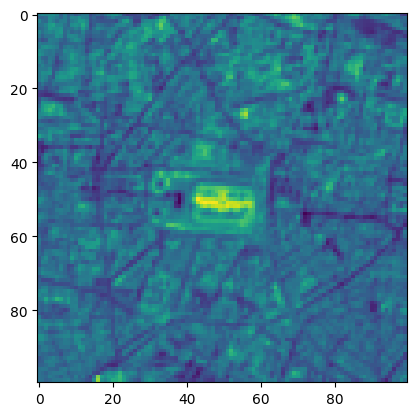

In [193]:
dataset_mlc = RasterTorchGeo('/home/waramz/Documents/INRIA_Pl@ntNet/git/malpolon/malpolon/data/torchgeo/dataset/sentinel')
a = dataset_mlc[{'lon':3.87075, 'lat':43.61135, 'crs':dataset_mlc.crs_pyproj.geodetic_crs, 'units':'pixel', 'size': (100, 100)}]
plt.figure()
plt.imshow(a['image'][0])
plt.show()

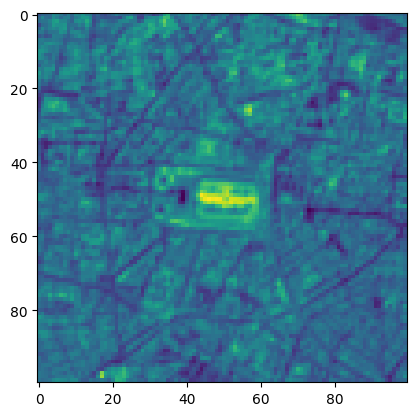

In [194]:
plt.figure()
plt.imshow(res_mlc['image'][0])
plt.show()

In [195]:
def subsampling(img, factor=4):
    img_sous_ech = np.empty([round(img.shape[0]/factor),round(img.shape[1]/factor)])
    img_sous_ech = img[1:img.shape[0]:factor,1:img.shape[1]:factor]
    return img_sous_ech

def chi2Distance(h1, h2):
    h1, h2 = np.array(h1[0]), np.array(h2[0])
    hdif = h1 - h2
    hsum = h1 + h2
    hdif, hsum = hdif.astype(np.float), hsum.astype(np.float)
    return 0.5*np.sum(np.nan_to_num(np.divide(np.square(hdif), hsum, out=np.zeros_like(hdif), where=hsum!=0)))

In [196]:
img1 = (torch.nn.functional.normalize(res_mlc['image'][0])*255).type(torch.uint8)
img2 = (torch.nn.functional.normalize(a['image'][0])*255).type(torch.uint8)
# img2 = np.zeros_like(img1)

hist1 = np.histogram(img1, bins=np.arange(0,256))
hist1 = [hist1[0], hist1[1][:-1]]
hist2 = np.histogram(img2, bins=np.arange(0,256))
hist2 = [hist2[0], hist2[1][:-1]]

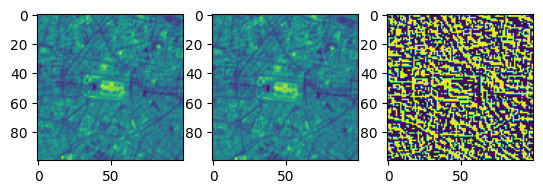

In [197]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(img1)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img1 - img2)
plt.show()

#print(hist1[0], hist2[0])

In [199]:
chi2Dist = chi2Distance(hist1, hist2)
if chi2Dist <= (img1.shape[0]*img1.shape[1])*0.05:
    print('Images are similar in histogram chi2 distance up to 5%')
else:
    print('Images are different in histogram chi2 distance for at least 5%')


<string>:1: RuntimeWarning: invalid value encountered in divide
<string>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Images are similar in histogram chi2 distance up to 5%


/tmp/ipykernel_825142/1165281141.py:10: RuntimeWarning: invalid value encountered in divide
  return 0.5*np.sum(np.nan_to_num(np.divide(np.square(hdif), hsum)))


In [ ]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Impact Energy data with a color map
x = df['Longitude']
y = df['Latitude']
z = df['Impact Energy [kt]']
plt.scatter(x, y, s=20*z, c=z, alpha=0.6, vmin=0, vmax=threshold,
            cmap='autumn')
plt.colorbar(label='Impact Energy [kt]')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

first_year = df["Datetime"].min().strftime("%Y")
last_year = df["Datetime"].max().strftime("%Y")
plt.title("NASA: Fireballs Reported by Government Sensors\n" +     
          str(first_year) + " - " + str(last_year))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()